# Testing of Temperature REMD

## Setup

In [1]:
using ReplicaExchangeMD

In [2]:
using Plots

In [3]:
Threads.nthreads()

8

## System Parameters

In [4]:
n_atoms = 100
atom_mass = 10.0u"u"
atoms = [Atom(mass=atom_mass, σ=0.3u"nm", ϵ=0.2u"kJ * mol^-1") for i in 1:n_atoms];

In [5]:
boundary = CubicBoundary(2.0u"nm", 2.0u"nm", 2.0u"nm")
coords = place_atoms(n_atoms, boundary, 0.3u"nm"); # Random placement without clashing

In [6]:
temp = 100.0u"K"
velocities = [velocity(atom_mass, temp) for i in 1:n_atoms];

In [7]:
pairwise_inters = (LennardJones(),) # Don't forget the trailing comma!

(LennardJones{false, NoCutoff, Int64, Int64, Unitful.FreeUnits{(kJ, nm^-1, mol^-1), 𝐋 𝐌 𝐍^-1 𝐓^-2, nothing}, Unitful.FreeUnits{(kJ, mol^-1), 𝐋^2 𝐌 𝐍^-1 𝐓^-2, nothing}}(NoCutoff(), false, true, 1, 1, kJ nm^-1 mol^-1, kJ mol^-1),)

## Test Simulation for normal system

In [8]:
sys = System(
    atoms=atoms,
    pairwise_inters=pairwise_inters,
    coords=coords,
    velocities=velocities,
    boundary=boundary,
    loggers=(
        temp=TemperatureLogger(10),
        coords=CoordinateLogger(10),
    ),
)

System with 100 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[2.0 nm, 2.0 nm, 2.0 nm])

In [9]:
simulator = VelocityVerlet(
    dt=0.002u"ps",
    coupling=AndersenThermostat(temp, 1.0u"ps"),
);

In [10]:
simulate!(sys, simulator, 10_000)

System with 100 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[2.0 nm, 2.0 nm, 2.0 nm])

In [11]:
values(sys.loggers.temp)

1001-element Vector{Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}}:
 114.50509194842247 K
 112.84131857549181 K
  111.3860433060121 K
  108.3768488450904 K
 103.72663330412287 K
 104.02134187304289 K
 104.52517767247559 K
 104.17978166527833 K
 102.55196735946896 K
 101.79501702000547 K
                    ⋮
  92.68677315709242 K
  93.21227416603313 K
  94.71687606386232 K
  91.16413713661792 K
  90.32592656075978 K
   96.0614871648539 K
  96.32441305286652 K
  98.82403261740345 K
  99.50713227282853 K

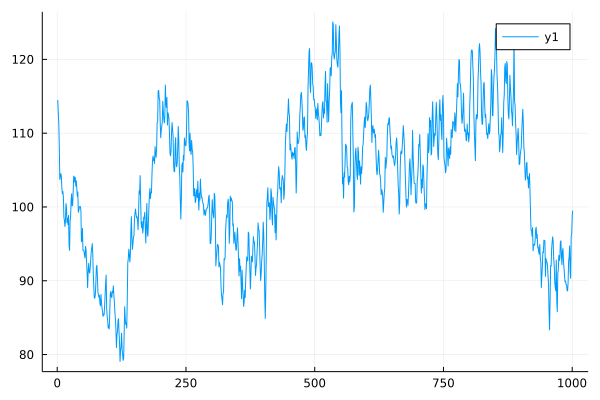

In [12]:
plot(ustrip.(values(sys.loggers.temp)))

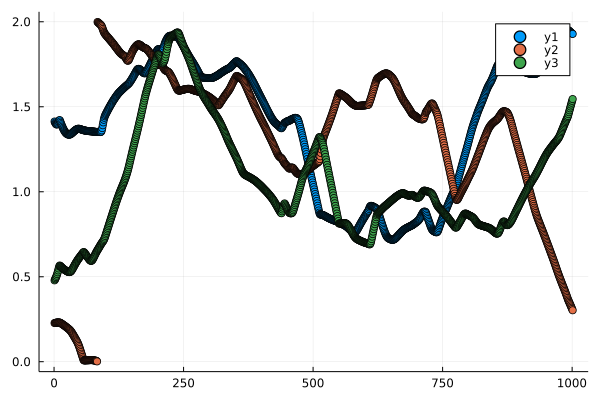

In [13]:
scatter([ustrip(c[50][1]) for c in values(sys.loggers.coords)])
scatter!([ustrip(c[50][2]) for c in values(sys.loggers.coords)])
scatter!([ustrip(c[50][3]) for c in values(sys.loggers.coords)])

# Test simulation for replica system

In [14]:
nb_matrix = trues(n_atoms, n_atoms)
for i in 1:(n_atoms ÷ 2)
    nb_matrix[i, i + (n_atoms ÷ 2)] = false
    nb_matrix[i + (n_atoms ÷ 2), i] = false
end

neighbor_finder = DistanceNeighborFinder(
    nb_matrix=nb_matrix,
    n_steps=10,
    dist_cutoff=1.5u"nm",
)

DistanceNeighborFinder{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}
  Size of nb_matrix = (100, 100)
  n_steps = 10
  dist_cutoff = 1.5 nm

In [36]:
repsys = ReplicaSystem(
    atoms=atoms,
    coords=coords,
    velocities=velocities,
    n_replicas=3,
    boundary=boundary,
    pairwise_inters=pairwise_inters,
    replica_loggers=Tuple((temp=TemperatureLogger(10), coords=CoordinateLogger(10)) for i in 1:3),
    neighbor_finder=neighbor_finder,
)

ReplicaSystem containing 3 replicas with 100 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[2.0 nm, 2.0 nm, 2.0 nm])

In [37]:
temp_vals = [120.0u"K", 160.0u"K", 200.0u"K"]
simulator = TemperatureREMD(
    dt=0.005u"ps",
    temperatures=temp_vals,
    simulators=[
        Langevin(
            dt=0.005u"ps",
            temperature=tmp,
            friction=0.1u"ps^-1",
        )
        for tmp in temp_vals],
    exchange_time=2.5u"ps",
);

In [38]:
simulate!(repsys, simulator, 20_000);

In [43]:
[(s, ind) for (s, ind) in zip(repsys.exchange_logger.steps, repsys.exchange_logger.indices)]

12-element Vector{Tuple{Int64, Tuple{Int64, Int64}}}:
 (5500, (1, 2))
 (6000, (2, 3))
 (9000, (1, 2))
 (10000, (2, 3))
 (10500, (2, 3))
 (15500, (1, 2))
 (17000, (3, 1))
 (17500, (2, 3))
 (18000, (2, 3))
 (18500, (2, 3))
 (19000, (2, 3))
 (19500, (3, 1))

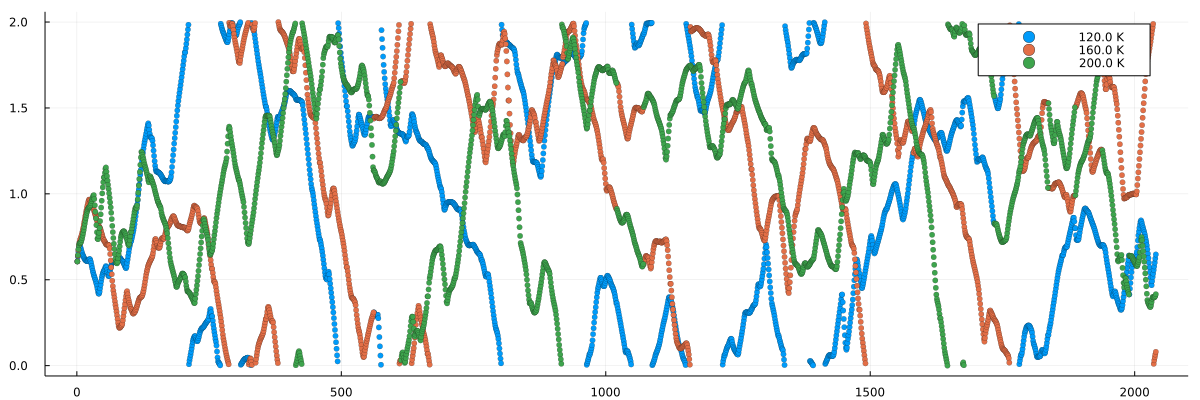

In [45]:
s = scatter([ustrip(c[10][1]) for c in values(repsys.replicas[1].loggers.coords)], label=temp_vals[1], markersize=3.0, markerstrokewidth=0.2, size=(1200, 400))
for repidx=2:3
    scatter!([ustrip(c[10][1]) for c in values(repsys.replicas[repidx].loggers.coords)], label=temp_vals[repidx], markersize=3.0, markerstrokewidth=0.2)
end
savefig(s, "plots/x_coordiantes_of_atom_7_in_each_replica.png")
s

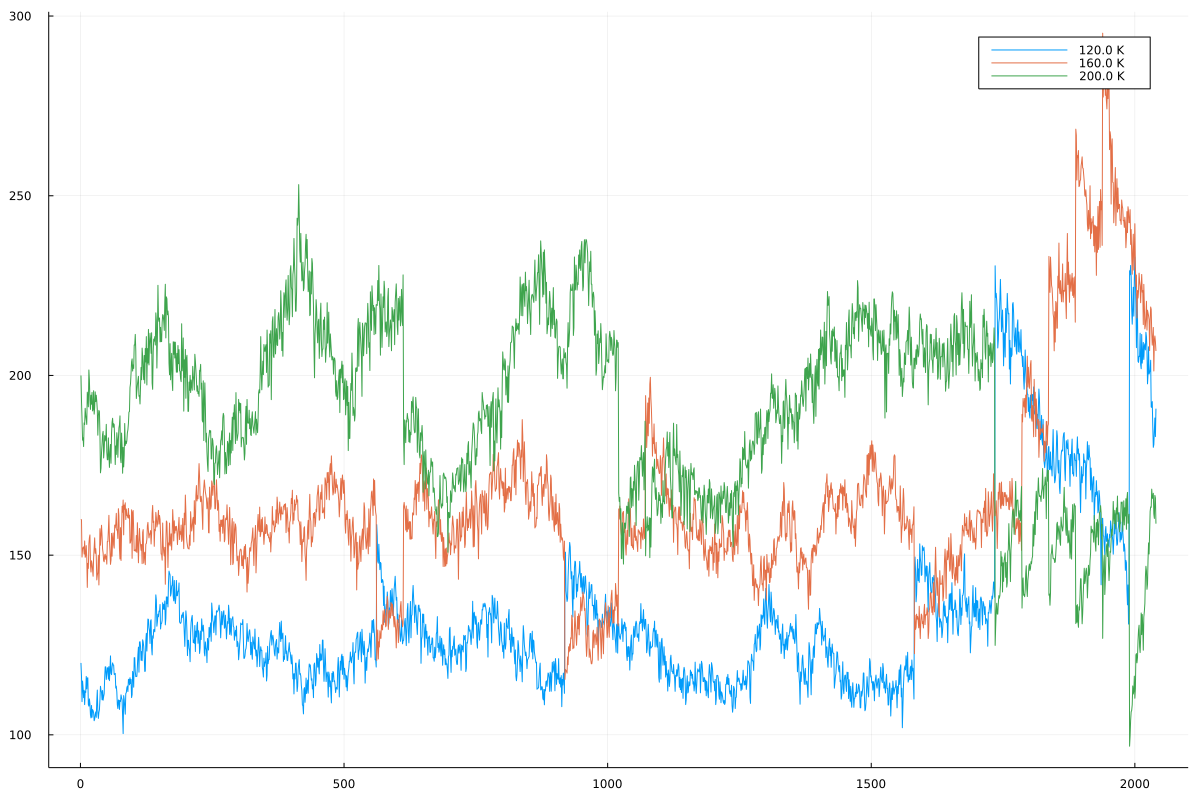

In [46]:
s = plot(ustrip.(values(repsys.replicas[1].loggers.temp)), label=temp_vals[1], linestyle=:solid, size=(1200, 800))
for repidx=2:3
    plot!(ustrip.(values(repsys.replicas[repidx].loggers.temp)), label=temp_vals[repidx], linestyle=:solid)
end
# s = vline!([i÷10 for i in repsys.exchange_logger.steps], color=:black, linewidth=1.5, linestyle=:dash, label="exchanges")
savefig(s, "plots/temperature_of_each_replica.png")
s

In [47]:
using Statistics

for repidx=1:3
    mean(ustrip.(values(repsys.replicas[repidx].loggers.temp))) |> println
end

133.75804885808216
165.30896082451264
189.5477482218355
